In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import shap

In [2]:
ROOT = os.path.join(os.getcwd(), 'Statsbomb_data\open-data-master')
DATA = os.path.join(ROOT, 'data')
FINAL_DF = os.path.join(ROOT,'final_dataframes')

# Import final dataframe

In [3]:
df = pd.read_pickle(
    filepath_or_buffer=os.path.join(FINAL_DF,'final_df.pkl')
)

In [4]:
df

,player,first_touch,open_goal,under_pressure,shot_technique,shot_body_part,statsbomb_xg,goal,aerial_shot,from_play,one_v_one,event_id
0,Gonçalo Manuel Ganchinho Guedes,False,False,False,Normal,Right Foot,0.008752,False,True,Throw In,False,2258c11c-0916-4976-bfde-a66e89ffeb8d
1,Santiago Mina Lorenzo,False,False,False,Normal,Right Foot,0.053915,False,True,Free Kick,False,f0be7ddf-1e01-4315-aee1-8d5fda52a739
2,Jordi Alba Ramos,True,False,False,Normal,Left Foot,0.080842,False,True,Throw In,False,bb173d27-76c4-4044-b883-8bd6f8450cf2
3,Luis Alberto Suárez Díaz,True,False,False,Normal,Right Foot,0.456472,True,True,Throw In,False,7b02c827-3580-4149-9912-216ce2bd544f
4,Gonçalo Manuel Ganchinho Guedes,False,False,False,Normal,Right Foot,0.025283,False,True,Regular Play,False,3b15d864-8738-4cb1-8275-f94277570223
...,...,...,...,...,...,...,...,...,...,...,...,...
21772,Sjaak Swart,False,False,False,Normal,Head,0.034801,False,True,Free Kick,False,62130924-f82f-4772-a4ef-a11fecaa51c2
21773,Gerrie Mühren,True,False,False,Normal,Left Foot,0.060509,False,True,Regular Play,False,478faba8-6898-4d23-a74c-fa23672e5b50
21774,Roberto Boninsegna,False,False,True,Normal,Left Foot,0.036656,False,True,Regular Play,False,222ec97a-066c-4b4f-9bcf-afb4f842edf2
21775,Gianfranco Bedin,False,False,False,Normal,Left Foot,0.113855,False,True,Free Kick,False,70094b8a-f6a2-4b9a-8576-36fef59fe44a


# Creating a Baseline Model with Logistic Regression

### Preparing data for training

In [5]:
df.isnull().sum()

player            0
first_touch       0
open_goal         0
under_pressure    0
shot_technique    0
shot_body_part    0
statsbomb_xg      0
goal              0
aerial_shot       0
from_play         0
one_v_one         0
event_id          0
dtype: int64

In [6]:
encoded_df = pd.get_dummies(
    data=df,
    columns=['first_touch','open_goal','under_pressure','shot_technique','shot_body_part','goal','aerial_shot','from_play','one_v_one'],
    drop_first=True
)

In [7]:
encoded_df.columns

Index(['player', 'statsbomb_xg', 'event_id', 'first_touch_True',
       'open_goal_True', 'under_pressure_True', 'shot_technique_Diving Header',
       'shot_technique_Half Volley', 'shot_technique_Lob',
       'shot_technique_Normal', 'shot_technique_Overhead Kick',
       'shot_technique_Volley', 'shot_body_part_Left Foot',
       'shot_body_part_Other', 'shot_body_part_Right Foot', 'goal_True',
       'aerial_shot_True', 'from_play_Counter', 'from_play_Free Kick',
       'from_play_Goal Kick', 'from_play_Keeper', 'from_play_Kick Off',
       'from_play_Other', 'from_play_Regular Play', 'from_play_Throw In',
       'one_v_one_True'],
      dtype='object')

In [8]:
encoded_df['player']=encoded_df['player'].astype('category')
encoded_df['player']=encoded_df['player'].cat.codes

In [9]:
encoded_df

,player,statsbomb_xg,event_id,first_touch_True,open_goal_True,under_pressure_True,shot_technique_Diving Header,shot_technique_Half Volley,shot_technique_Lob,shot_technique_Normal,...,aerial_shot_True,from_play_Counter,from_play_Free Kick,from_play_Goal Kick,from_play_Keeper,from_play_Kick Off,from_play_Other,from_play_Regular Play,from_play_Throw In,one_v_one_True
0,512,0.008752,2258c11c-0916-4976-bfde-a66e89ffeb8d,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
1,1239,0.053915,f0be7ddf-1e01-4315-aee1-8d5fda52a739,0,0,0,0,0,0,1,...,1,0,1,0,0,0,0,0,0,0
2,689,0.080842,bb173d27-76c4-4044-b883-8bd6f8450cf2,1,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
3,867,0.456472,7b02c827-3580-4149-9912-216ce2bd544f,1,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
4,512,0.025283,3b15d864-8738-4cb1-8275-f94277570223,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21772,1286,0.034801,62130924-f82f-4772-a4ef-a11fecaa51c2,0,0,0,0,0,0,1,...,1,0,1,0,0,0,0,0,0,0
21773,496,0.060509,478faba8-6898-4d23-a74c-fa23672e5b50,1,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
21774,1164,0.036656,222ec97a-066c-4b4f-9bcf-afb4f842edf2,0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
21775,498,0.113855,70094b8a-f6a2-4b9a-8576-36fef59fe44a,0,0,0,0,0,0,1,...,1,0,1,0,0,0,0,0,0,0


In [10]:
dependent = encoded_df.drop(['goal_True'],axis=1)
target = encoded_df['goal_True']

In [11]:
dependent_train, dependent_test, target_train, target_test = train_test_split(dependent, target, test_size = 0.3)

In [15]:
baseline =  LogisticRegression(max_iter=1000)
baseline.fit(dependent_train.drop(['statsbomb_xg','event_id'],axis=1), target_train)

LogisticRegression(max_iter=1000)

# Prediction

In [17]:
predictions = baseline.predict(dependent_test.drop(['statsbomb_xg','event_id'],axis=1))

In [18]:
predictions

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [19]:
target_test

5032     0
3520     0
3249     0
10254    0
17008    0
        ..
7168     0
15101    0
4145     1
14243    0
17084    0
Name: goal_True, Length: 6534, dtype: uint8

In [21]:
test_xG = baseline.predict_proba(dependent_test.drop(['statsbomb_xg','event_id'],axis=1))[:,1]

In [22]:
metrics.mean_squared_error(y_true=dependent_test.drop(['event_id'],axis=1)['statsbomb_xg'], y_pred=test_xG)

0.012115185662588287

In [19]:
score = baseline.score(X=dependent_test.drop('statsbomb_xg',axis=1), y=target_test)
print(f"Test Accuracy Score: {score}")

Test Accuracy Score: 0.8898071625344353


In [20]:
error = np.subtract(
    dependent_test['statsbomb_xg'],
    test_xG
)

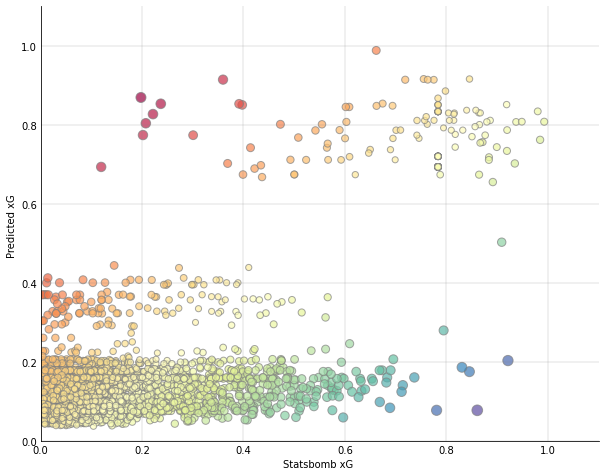

In [21]:

plt.figure(figsize=(10,8))
plt.xlim(0,1.1)
plt.ylim(0,1.1)
plt.grid(
    color='gray',
    alpha=0.15,
    linewidth=1.5
)
g=plt.scatter(
    dependent_test['statsbomb_xg'],
    test_xG,
    s=(plt.rcParams['lines.markersize'] * (1+np.absolute(error))) ** 2,
    c=error,
    alpha=0.7,
    edgecolors='gray',
    cmap='Spectral'
)
g.axes.set_xlabel('Statsbomb xG ')
g.axes.set_ylabel('Predicted xG ')
g.axes.spines[['right', 'top']].set_visible(False)
g.axes.tick_params(axis=u'both', which=u'both',length=0) # Credit: https://stackoverflow.com/questions/29988241/hide-ticks-but-show-tick-labels

# Feature Importance

Content taken from: https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html

In [22]:
def baseline_proba(x,baseline=baseline):
    return baseline.predict_proba(x)[:, 1]


def baseline_log_odds(x,baseline=baseline):
    p = baseline.predict_log_proba(x)
    return p[:, 1] - p[:, 0]

In [25]:
dependent_train.columns

Index(['player', 'statsbomb_xg', 'first_touch_True', 'open_goal_True',
       'under_pressure_True', 'shot_technique_Diving Header',
       'shot_technique_Half Volley', 'shot_technique_Lob',
       'shot_technique_Normal', 'shot_technique_Overhead Kick',
       'shot_technique_Volley', 'shot_body_part_Left Foot',
       'shot_body_part_Other', 'shot_body_part_Right Foot', 'aerial_shot_True',
       'from_play_Counter', 'from_play_Free Kick', 'from_play_Goal Kick',
       'from_play_Keeper', 'from_play_Kick Off', 'from_play_Other',
       'from_play_Regular Play', 'from_play_Throw In', 'one_v_one_True'],
      dtype='object')

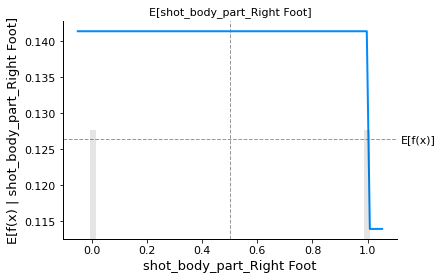

In [27]:
# make a standard partial dependence plot
sample_ind = 18
fig, ax = shap.partial_dependence_plot(
    "shot_body_part_Right Foot",
    baseline_proba,
    dependent_train.drop('statsbomb_xg',axis=1),
    model_expected_value=True,
    feature_expected_value=True,
    show=False,
    ice=False,
)

In [29]:
# compute the SHAP values for the linear model
background_adult = shap.maskers.Independent(dependent_train.drop('statsbomb_xg',axis=1), max_samples=100)
explainer = shap.Explainer(baseline_proba, background_adult)
shap_values = explainer(dependent_train.drop('statsbomb_xg',axis=1)[:1000])

PermutationExplainer explainer: 1001it [00:50, 17.35it/s]                         


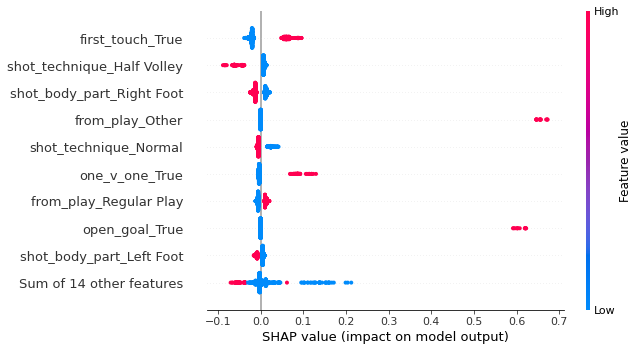

In [31]:
shap.plots.beeswarm(shap_values)